In [1]:
from __future__ import division
import argparse
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, metrics
from ops import *
from utils import *
import shutil
from tqdm import tqdm
from numpy import asarray
from numpy.random import randn
from numpy.random import randint

from evaluation import get_mean_cov_for_each_label, frechet_distance
import pandas as pd

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
class Discriminator(tf.keras.Model):
    def __init__(self, is_training=True):
        super(Discriminator, self).__init__(name='discriminator')
        self.is_training = is_training
        self.conv_1 = Conv2D(64, 4, 2)
        self.conv_2 = Conv2D(128, 4, 2)
        self.bn_1=BatchNorm(is_training=self.is_training)
        self.bn_2=BatchNorm(is_training=self.is_training)
        self.fc_1 = DenseLayer(1024)
        self.fc_2 = DenseLayer(1)

    def call(self, inputs, training):
        x = self.conv_1(inputs)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = self.conv_2(x)
        x = self.bn_1(x, training)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Flatten()(x)
        x = self.fc_1(x)
        x = self.bn_2(x, training)
        x = layers.LeakyReLU(alpha=0.2)(x)
        out_logits = self.fc_2(x)
        out = keras.activations.sigmoid(out_logits)
        return out, out_logits, x
    
    def build_graph(self, shape):
        x = Input(shape=shape)
        return Model(inputs=[x],outputs=self.call(x,True))

In [3]:
class Generator(tf.keras.Model):
    def __init__(self, is_training=True):
        super(Generator, self).__init__(name='generator')
        self.is_training = is_training
        self.fc_1 = DenseLayer(1024)
        self.fc_2 = DenseLayer(128*7*7)
        self.bn_1=BatchNorm(is_training=self.is_training)
        self.bn_2=BatchNorm(is_training=self.is_training)
        self.bn_3=BatchNorm(is_training=self.is_training)
        self.up_conv_1 = UpConv2D(64, 4, 2)
        self.up_conv_2 = UpConv2D(1, 4, 2)

    def call(self, inputs, training):
        x = self.fc_1(inputs)
        x = self.bn_1(x, training)
        x = layers.ReLU()(x)
        x = self.fc_2(x)
        x = self.bn_2(x, training)
        x = layers.ReLU()(x)
        x = layers.Reshape((7, 7, 128))(x)
        x = self.up_conv_1(x)
        x = self.bn_3(x, training)
        x = layers.ReLU()(x)
        x = self.up_conv_2(x)
        x = keras.activations.sigmoid(x)
        return x
    
    def build_graph(self, shape):
        x = Input(shape=shape)
        return Model(inputs=[x],outputs=self.call(x,True))

In [4]:
class CGAN():
    def __init__(self, args):
        super(CGAN, self).__init__()
        # The name of the model.
        self.model_name = args['gan_type']
        # Batch size. Used in training.
        self.batch_size = args['batch_size']
        # Number of dimensions of the random noize vector
        # for each sample.
        self.z_dim = args['z_dim']
        # 'self.batch_size' number of random noize vectors.
        self.sample_z = np.random.uniform(
            -1, 1, size=(self.batch_size, self.z_dim)).astype(np.float32)
        # Number of dimensions of labels (y).
        self.y_dim = 10
        # The name of the dataset.
        self.datasets_name = args['datasets']

        # Directory of the checkpoints.
        self.checkpoint_dir = check_folder(
            os.path.join(
                args['checkpoint_dir'], self.model_name, self.datasets_name))
        # Directory of the log information during training.
        self.log_dir = os.path.join(
            args['log_dir'], self.model_name, self.datasets_name)
        # Directory of the results during running.
        self.result_dir = args['result_dir']

        # Learning rate
        self.learnning_rate = args['lr']
        # Number of epoches.
        self.epoches = args['epoch']
        # Dataset
        self.datasets = load_mnist_data(
            datasets=self.datasets_name, batch_size=args['batch_size'])

        # Geneartor.
        self.g = Generator(is_training=True)
        # Discriminator.
        self.d = Discriminator(is_training=True)

        # Plot the compontents.
        self._plot()
        
        # Optimizer of the generator.
        self.g_optimizer = optimizers.Adam(
            lr=5*self.learnning_rate, beta_1=0.5)
        # Optimizer of the discriminator.
        self.d_optimizer = optimizers.Adam(
            lr=self.learnning_rate, beta_1=0.5)

        # Metric used in training. Note that it is only used for evaluation
        # during training, and not used for updating prameters during training.
        self.g_loss_metric = metrics.Mean('g_loss', dtype=tf.float32)
        self.d_loss_metric = metrics.Mean('d_loss', dtype=tf.float32)
        self.g_acc_metric = tf.keras.metrics.Mean('g_acc', dtype=tf.float32)
        self.d_acc_metric = tf.keras.metrics.Mean('d_acc', dtype=tf.float32)

        # Checkpoints
        self.checkpoint = tf.train.Checkpoint(
            step=tf.Variable(0),
            generator_optimizer=self.g_optimizer,
            discriminator_optimizer=self.d_optimizer,
            generator=self.g,
            discriminator=self.d)
        self.manager = tf.train.CheckpointManager(
            self.checkpoint, self.checkpoint_dir, max_to_keep=3)

    @property
    def model_dir(self):
        """
        Name of the model which includes model_name, 
        datasets_name, batch_size, z_dim.
        """
        return "{}_{}_{}_{}".format(
            self.model_name, self.datasets_name,
            self.batch_size, self.z_dim)

    def d_loss_fun(self, d_fake_logits, d_real_logits):
        """
        Loss function of the discriminator. This this the loss function
        which is used for updating parameters during training.
        """
        d_loss_real = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_real_logits), logits=d_real_logits))
        d_loss_fake = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_fake_logits), logits=d_fake_logits))
        total_loss = d_loss_fake+d_loss_real
        return total_loss

    def d_acc_fun(self, d_fake, d_real):
        """
        Accuracy of discriminator during training of discriminator.
        """
        acc_fake = tf.reduce_mean(tf.cast(tf.less(d_fake, 0.5), tf.float32))
        acc_real = tf.reduce_mean(tf.cast(tf.greater(d_real, 0.5), tf.float32))
        acc = 0.5*(acc_fake + acc_real)
        return acc

    def g_loss_fun(self, logits):
        """
        Loss function of the generator. This this the loss function
        which is used for updating parameters during training.
        """
        g_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=tf.ones_like(logits),
                logits=logits))
        return g_loss

    def g_acc_fun(self, d_fake):
        """
        Accuracy of discriminator during training of generator.
        """
        acc_fake = tf.reduce_mean(tf.cast(tf.less(d_fake, 0.5), tf.float32))
        return acc_fake

    @tf.function
    def train_one_step(self, batch_labels, batch_images):
        """
        Train for one batch.
        """
        # Noise vectors for this batch.
        noises = np.random.uniform(-1, 1, [self.batch_size, self.z_dim])
        # Concatenate the noise and label for a batch of samples.
        batch_z = tf.concat([noises, batch_labels], 1)
        #real_images = batch_images
        real_images = conv_cond_concat(batch_images, batch_labels)
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            fake_imgs = self.g(batch_z, training=True)
            fake_imgs = conv_cond_concat(fake_imgs, batch_labels)
            d_fake, d_fake_logits, input4classifier_fake = self.d(
                fake_imgs, training=True)
            d_real, d_real_logits, input4classifier_real = self.d(
                real_images, training=True)
            d_loss = self.d_loss_fun(d_fake_logits, d_real_logits)
            d_acc = self.d_acc_fun(d_fake, d_real)

            g_loss = self.g_loss_fun(d_fake_logits)
            g_acc = self.g_acc_fun(d_fake)

        # Compute gradients.
        gradients_of_d = d_tape.gradient(d_loss, self.d.trainable_variables)
        gradients_of_g = g_tape.gradient(g_loss, self.g.trainable_variables)

        # Update parameters.
        self.d_optimizer.apply_gradients(
            zip(gradients_of_d, self.d.trainable_variables))
        self.g_optimizer.apply_gradients(
            zip(gradients_of_g, self.g.trainable_variables))

        # Record metrics
        self.g_loss_metric(g_loss)
        self.d_loss_metric(d_loss)

        self.g_acc_metric(g_acc)
        self.d_acc_metric(d_acc)

        return g_loss, d_loss, g_acc, d_acc

    def train(self, load=False):
        """
        Train the CGAN model.

        Args:
            load: True iff try to load trained model.
        """
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        train_log_dir = os.path.join(self.log_dir, current_time)
        self.train_summary_writer = tf.summary.create_file_writer(
            train_log_dir)

        # if want to load a checkpoints,set load flags to be true
        if load:
            self.could_load = self.load_ckpt()
        else:
            start_epoch = 0
        ckpt_step = int(self.checkpoint.step)
        # Number of epochs that has been trained before.
        start_epoch = int((ckpt_step*self.batch_size)//60000)

        # Value of metrics during training.
        g_losses = []
        d_losses = []
        g_accs = []
        d_accs = []
        # Train.
        for epoch in tqdm(range(start_epoch, self.epoches)):
            for batch_images, batch_labels in self.datasets:
                if int(self.checkpoint.step) == 0 or self.could_load:
                    # Should not try to load trained models after the
                    # first batch of training.
                    self.could_load = False
                    # Use one batch of samples of labels as test labels
                    # for all training batches.
                    self.test_labels = batch_labels[0:self.batch_size]
                # Train one step.
                g_loss, d_loss, g_acc, d_acc\
                    = self.train_one_step(batch_labels, batch_images)
                g_losses.append(g_loss)
                d_losses.append(d_loss)
                g_accs.append(g_acc)
                d_accs.append(d_acc)

                self.checkpoint.step.assign_add(1)
                step = int(self.checkpoint.step)

                # For every 1000 batches training, generate and save images
                # for test labels.
                if step % 1000 == 0:
                    print('step： {}, d_loss: '
                          '{:.4f}, g_loss: {:.4F}'.format(
                              step, self.d_loss_metric.result(),
                              self.g_loss_metric.result()
                          ))
                    # Number of images generated for each column of a figure
                    manifold_h = int(np.floor(np.sqrt(self.batch_size)))
                    # Number of images generated for each row of a figure
                    manifold_w = int(np.floor(np.sqrt(self.batch_size)))
                    self.batch_z_to_disply = tf.concat(
                        [self.sample_z,
                         self.test_labels[:self.batch_size, :]], 1
                    )
                    result_to_display = self.g(
                        self.batch_z_to_disply, training=False)
                    imsave(result_to_display[:manifold_h * manifold_w, :, :, :],
                           [manifold_h, manifold_w],
                           './' + check_folder(
                        self.result_dir + '/' + self.model_dir)
                        + '/' + self.model_name +
                        '_train_{:02d}_{:04d}.png'.format(epoch, int(step)),
                        show=True)

                 # For every 50 batches, log metrics
                if step % 50 == 0:
                    with self.train_summary_writer.as_default():
                        tf.summary.scalar(
                            'g_loss', self.g_loss_metric.result(), step=step)
                        tf.summary.scalar(
                            'd_loss', self.d_loss_metric.result(), step=step)

                    self.g_loss_metric.reset_states()
                    self.d_loss_metric.reset_states()

                # save checkpoints for every 400 batches training
                if step % 500 == 0:
                    save_path = self.manager.save()
#                     print("\n----------Saved checkpoint for step {}: "
#                         "{}-------------\n".format(step, save_path))

        return g_losses, d_losses, g_accs, d_accs

    def load_ckpt(self):
        """
        Try to load the latest checkpoint. Return True iff a latest
        checkpoint is loaded.
        """
        self.checkpoint.restore(self.manager.latest_checkpoint)
        if self.manager.latest_checkpoint:
            print("restore model from checkpoint:  {}".format(
                self.manager.latest_checkpoint))
            return True

        else:
            print("Initializing from scratch.")
            return False
        
    def _plot(self):
        """
        Plot me. 
        """
        prefix = './' + check_folder(self.result_dir + '/' + self.model_dir) + '/' + self.model_name
        
        model_g = self.g.build_graph(self.z_dim + self.y_dim)
        print('geneartor')
        model_g.summary()
        tf.keras.utils.plot_model(model_g, prefix + '_generator.png', show_shapes=True)
        
        # Look at conv_cond_concat() to know how to compute the shape.
        it = iter(self.datasets)
        d_shape = list(next(it)[0].shape[1:])
        d_shape[-1] += self.y_dim
        model_d = self.d.build_graph(tuple(d_shape))
        print('discriminator')
        model_d.summary()
        tf.keras.utils.plot_model(model_d, prefix + '_discriminator.png', show_shapes=True)

In [5]:
def get_args():
    """
    Get default parameters to intialize CGAN model.
    
    Returns: 
        A dictionary of arguments to intialize CGAN model.
    """
    args = {}
    args['datasets'] = 'mnist'
    args['gan_type'] = 'CGAN'
    args['lr'] = 2e-4
    # total number of epochs to train. If we load and train the previously
    # trained model. This number includes what has been trained epochs.
    # We normally train 15 epochs.
    args['epoch'] = 15
    args['epoch'] = 15
    args['batch_size'] = 64
    args['z_dim'] = 62
    args['checkpoint_dir'] = 'checkpoint'
    args['result_dir'] = 'results'
    args['log_dir'] = 'logs'
    return args

In [6]:
def main(args):
    """
    Initiate and train an CGAN model.
    
    Return: 
        The training log and the trained model.
    """
    model = CGAN(args)
    train_res = model.train(load=False)
    return train_res, model

# Mnist

## Train

In [7]:
# # Delete all previous training results
# if 'logs' in os.listdir():
#     shutil.rmtree('./logs')
# if './checkpoinot' in os.listdir():
#     shutil.rmtree('./checkpoint')
# if './results' in os.listdir():
#     shutil.rmtree('./results')

In [8]:
# Set parameters
args = get_args()
args['datasets'] = 'mnist'
# Set epoch to a small number just to test the code
args['epoch'] = 15

geneartor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 72)]              0         
_________________________________________________________________
dense_layer (DenseLayer)     (None, 1024)              74752     
_________________________________________________________________
batch_norm (BatchNorm)       (None, 1024)              4096      
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0         
_________________________________________________________________
dense_layer_1 (DenseLayer)   (None, 6272)              6428800   
_________________________________________________________________
batch_norm_1 (BatchNorm)     (None, 6272)              25088     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 6272)          

  0%|          | 0/15 [00:00<?, ?it/s]

discriminator
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 11)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        11328     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         131200    
_________________________________________________________________
batch_norm_3 (BatchNorm)     (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)    

  7%|▋         | 1/15 [00:07<01:40,  7.20s/it]

step： 1000, d_loss: 1.3737, g_loss: 0.7138


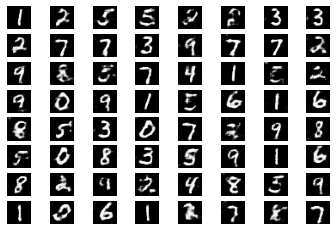

 13%|█▎        | 2/15 [00:13<01:30,  6.97s/it]

step： 2000, d_loss: 1.3711, g_loss: 0.7073


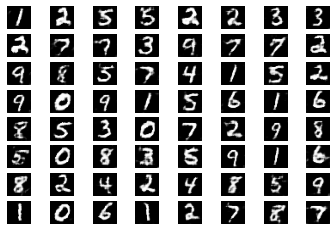

 20%|██        | 3/15 [00:20<01:21,  6.82s/it]

step： 3000, d_loss: 1.3727, g_loss: 0.7088


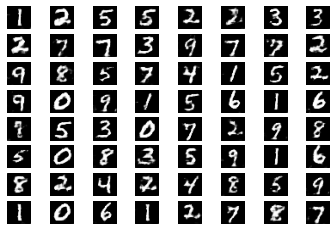

 27%|██▋       | 4/15 [00:26<01:14,  6.74s/it]

step： 4000, d_loss: 1.3722, g_loss: 0.7145


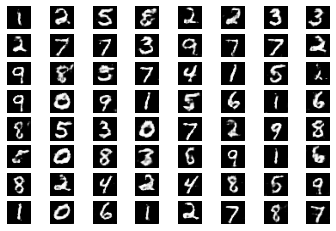

 33%|███▎      | 5/15 [00:33<01:06,  6.67s/it]

step： 5000, d_loss: 1.3707, g_loss: 0.7118


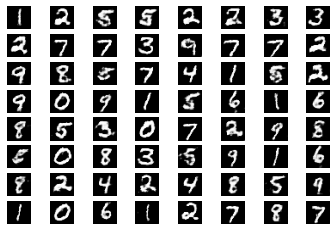

 40%|████      | 6/15 [00:39<00:59,  6.60s/it]

step： 6000, d_loss: 1.3743, g_loss: 0.7135


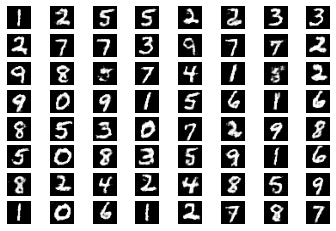

 47%|████▋     | 7/15 [00:46<00:52,  6.57s/it]

step： 7000, d_loss: 1.3673, g_loss: 0.7146


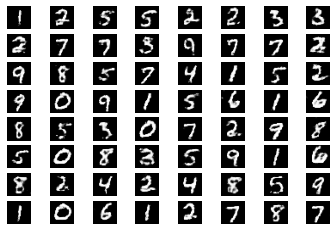

 53%|█████▎    | 8/15 [00:52<00:45,  6.47s/it]

step： 8000, d_loss: 1.3734, g_loss: 0.7093


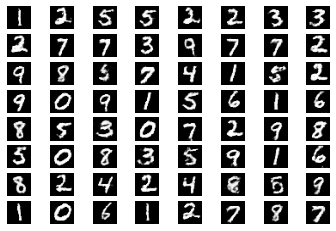

 60%|██████    | 9/15 [00:58<00:38,  6.46s/it]

step： 9000, d_loss: 1.3731, g_loss: 0.7157


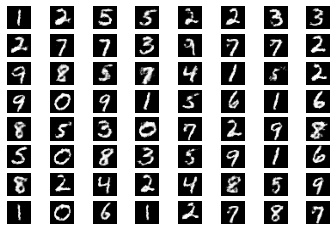

 67%|██████▋   | 10/15 [01:05<00:32,  6.51s/it]

step： 10000, d_loss: 1.3767, g_loss: 0.7085


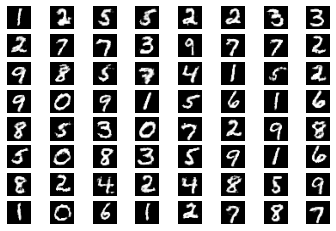

 73%|███████▎  | 11/15 [01:11<00:26,  6.50s/it]

step： 11000, d_loss: 1.3703, g_loss: 0.7086


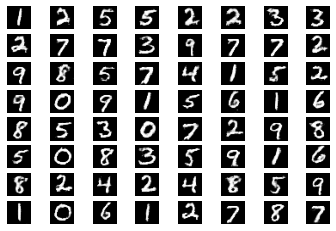

 80%|████████  | 12/15 [01:18<00:19,  6.53s/it]

step： 12000, d_loss: 1.3755, g_loss: 0.7110


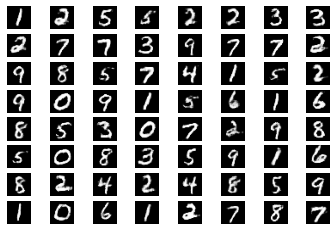

 87%|████████▋ | 13/15 [01:24<00:12,  6.48s/it]

step： 13000, d_loss: 1.3725, g_loss: 0.7101


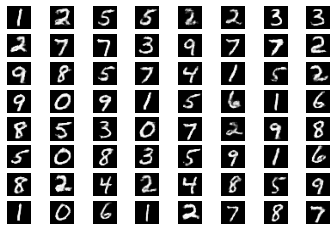

 93%|█████████▎| 14/15 [01:31<00:06,  6.47s/it]

step： 14000, d_loss: 1.3721, g_loss: 0.7095


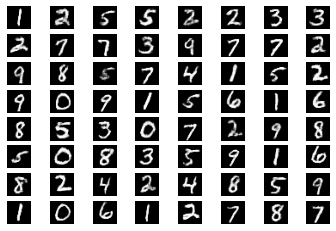

100%|██████████| 15/15 [01:37<00:00,  6.52s/it]


In [9]:
train_res_mnist, model_mnist = main(args)
train_res_mnist = np.array(train_res_mnist)

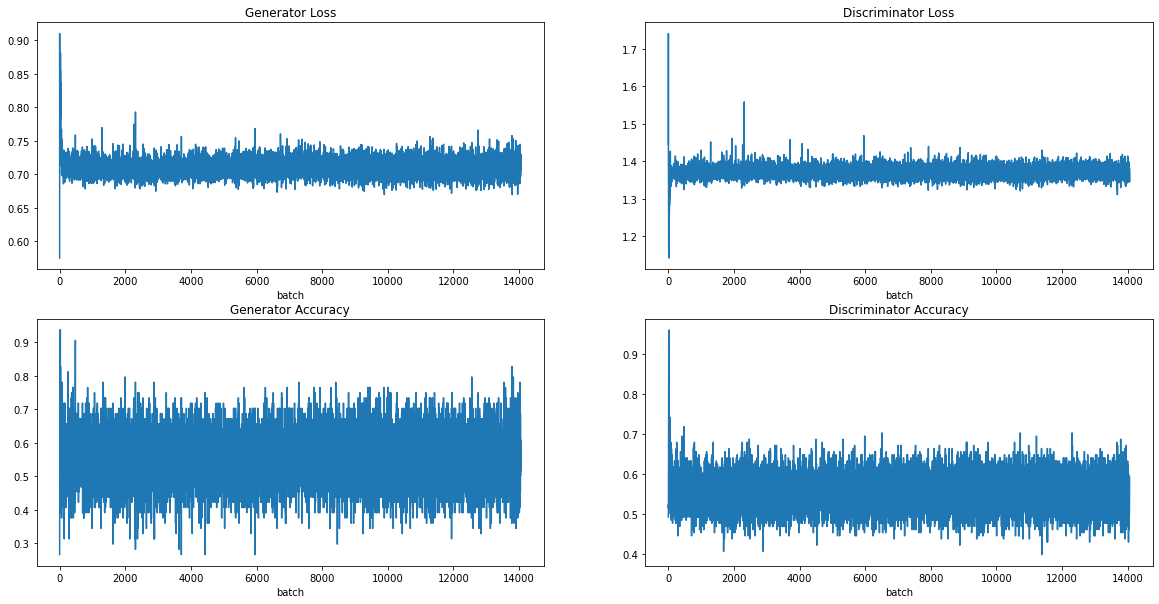

In [10]:
titles = ['Generator Loss','Discriminator Loss',
          'Generator Accuracy', 'Discriminator Accuracy']
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.reshape(-1)
for i in range(len(axes)):
    axes[i].plot(train_res_mnist[i])
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('batch')

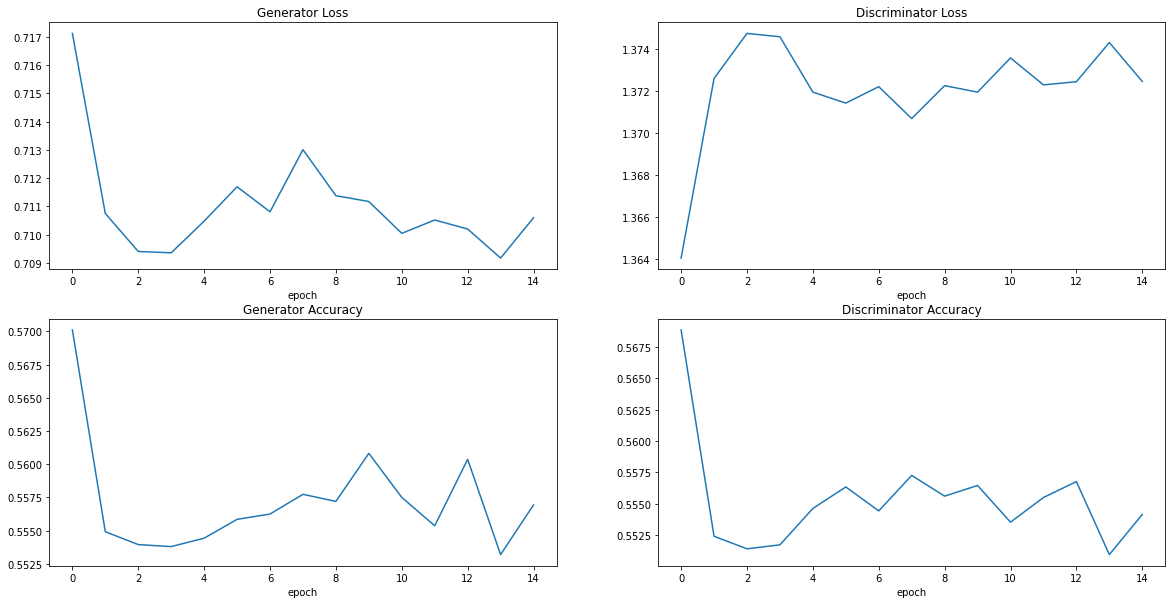

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.reshape(-1)
n_train = 60000
for i in range(len(axes)):
    train_log_epoch = batch_to_epoch(train_res_mnist[i], n_train // args['batch_size'])
    axes[i].plot(range(len(train_log_epoch)), train_log_epoch, '-')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('epoch')

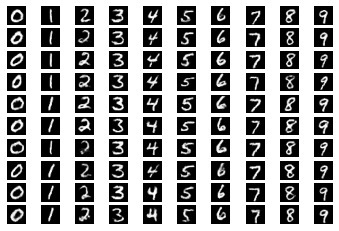

In [12]:
# Get the trained generator
trained_generator_mnist = model_mnist.g
size = (10, 10)
# generate noise (latent_points) and labels
latent_points, _ = generate_latent_points(
    model_mnist.z_dim, 100, 'uniform')
labels = asarray([x for _ in range(10) for x in range(10)])
labels = tf.one_hot(labels, 10).numpy()
# Get input to the generator
batch_z_to_disply = np.concatenate([latent_points, labels], 1)
X = trained_generator_mnist(batch_z_to_disply, training=False)
imsave(X, size, show=True)

## Evaluation

In [13]:
# Get real disbrituion for each label.
# Image data: values are transformed to [0, 1],
#             same as that of generator outputs.
# Dictionary stats_real, example: stats[0] = [mean_0, cov_0]
stats_real = get_mean_cov_for_each_label(datasets='mnist')


# Calculate FID for each label.
# 1. For each label i,
#    use 1000 fake images to calculate the generated distribution.
# 2. Then calculate fid for each label using fake & real distribution.
nClass = 10
fake_num = 6400
stats_fake = {}

trained_generator_mnist = model_mnist.g # mnist generator
latent_points, _ = generate_latent_points(model_mnist.z_dim, fake_num, 'uniform')

for i in range(nClass):
    labels = np.full(shape=(fake_num,), fill_value=i, dtype=np.int32)
    labels = tf.one_hot(labels, 10).numpy()
    # Get input to the generator
    batch_z_to_disply = np.concatenate([latent_points, labels], 1)
    X = trained_generator_mnist(batch_z_to_disply, training=False)
    fake_values = X.numpy().reshape(X.shape[0], -1)
    # generated values should be in [0, 1], because used sigmoid activation
    assert np.min(fake_values) >= -0.01 and np.max(fake_values) <= 1.01
    mean = fake_values.mean(axis=0)
    cov = np.cov(fake_values.T) # 784 x 784
    stats_fake[i] = [mean, cov]
    
fid_list = [] # smaller == better
for i in range(nClass):
    m, c = stats_real[i]
    m_fake, c_fake = stats_fake[i]
    fid_list.append(frechet_distance(m, c, m_fake, c_fake))

dataset mnist


/home/featurize/data/deep_learning_project/cgan/GANs-collections-tf2.0_keras-eager_mode/evaluation.py:59: Warning: Rank deficient covariance matrix, Frechet distance will not be accurate.
  'Frechet distance will not be accurate.', Warning)


In [14]:
# fid_list = [1,1,2,1.0,2,1,0.1,0.01,1,0]
mnist_result = pd.DataFrame()
mnist_result['label'] = [str(i) for i in range(nClass)] + ['average']
mnist_result['Frechet Inception Distance - MNIST'] = list(fid_list) + [np.mean(fid_list)]
mnist_result.set_index('label')

,Frechet Inception Distance - MNIST
label,
0,26.097890
1,9.676800
2,21.680880
3,22.092979
4,14.682638
5,17.870654
6,15.590251
7,18.433470
8,21.124631


# Fashion Mnist

## Train

In [15]:
# Set parameters
args = get_args()
args['datasets'] = 'fashion_mnist'
# Set epoch to a small number just to test the code
args['epoch'] = 15

geneartor
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 72)]              0         
_________________________________________________________________
dense_layer_4 (DenseLayer)   (None, 1024)              74752     
_________________________________________________________________
batch_norm_5 (BatchNorm)     (None, 1024)              4096      
_________________________________________________________________
re_lu_78 (ReLU)              (None, 1024)              0         
_________________________________________________________________
dense_layer_5 (DenseLayer)   (None, 6272)              6428800   
_________________________________________________________________
batch_norm_6 (BatchNorm)     (None, 6272)              25088     
_________________________________________________________________
re_lu_79 (ReLU)              (None, 6272)        

  7%|▋         | 1/15 [00:06<01:25,  6.08s/it]

step： 1000, d_loss: 1.3756, g_loss: 0.7063


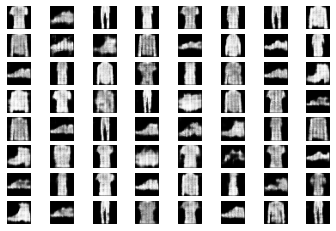

 13%|█▎        | 2/15 [00:12<01:21,  6.23s/it]

step： 2000, d_loss: 1.3770, g_loss: 0.7047


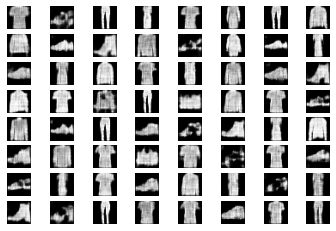

 20%|██        | 3/15 [00:19<01:15,  6.33s/it]

step： 3000, d_loss: 1.3772, g_loss: 0.7075


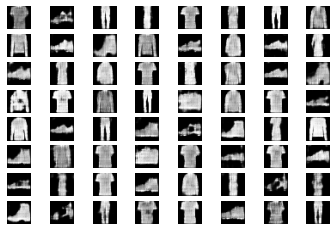

 27%|██▋       | 4/15 [00:25<01:10,  6.44s/it]

step： 4000, d_loss: 1.3716, g_loss: 0.7119


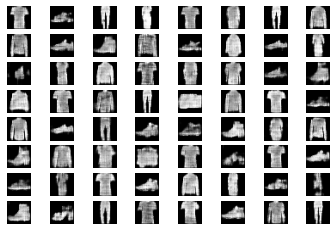

 33%|███▎      | 5/15 [00:32<01:05,  6.52s/it]

step： 5000, d_loss: 1.3699, g_loss: 0.7116


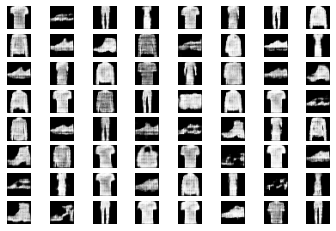

 40%|████      | 6/15 [00:39<00:58,  6.50s/it]

step： 6000, d_loss: 1.3688, g_loss: 0.7117


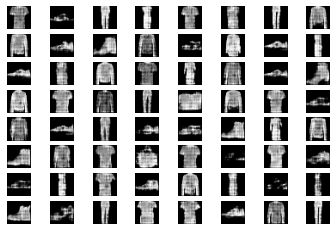

 47%|████▋     | 7/15 [00:45<00:52,  6.53s/it]

step： 7000, d_loss: 1.3702, g_loss: 0.7130


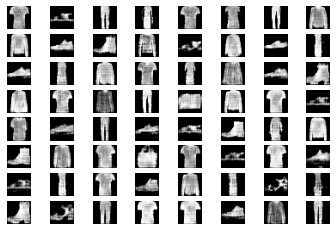

 53%|█████▎    | 8/15 [00:51<00:45,  6.46s/it]

step： 8000, d_loss: 1.3748, g_loss: 0.7087


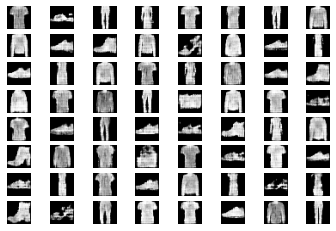

 60%|██████    | 9/15 [00:58<00:39,  6.53s/it]

step： 9000, d_loss: 1.3820, g_loss: 0.7033


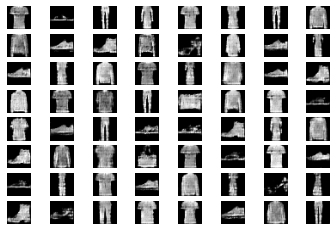

 67%|██████▋   | 10/15 [01:05<00:32,  6.58s/it]

step： 10000, d_loss: 1.3778, g_loss: 0.7041


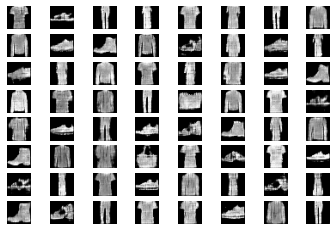

 73%|███████▎  | 11/15 [01:12<00:26,  6.68s/it]

step： 11000, d_loss: 1.3828, g_loss: 0.7062


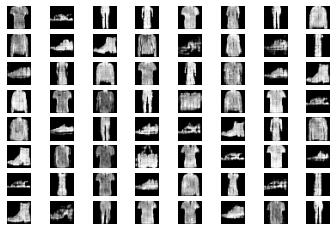

 80%|████████  | 12/15 [01:18<00:19,  6.60s/it]

step： 12000, d_loss: 1.3799, g_loss: 0.7098


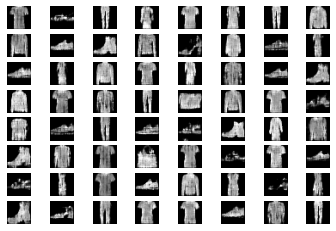

 87%|████████▋ | 13/15 [01:25<00:13,  6.60s/it]

step： 13000, d_loss: 1.3814, g_loss: 0.7052


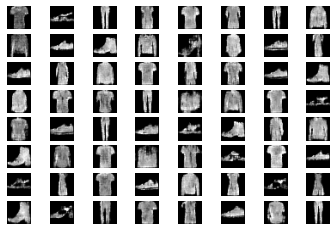

 93%|█████████▎| 14/15 [01:31<00:06,  6.55s/it]

step： 14000, d_loss: 1.3781, g_loss: 0.7021


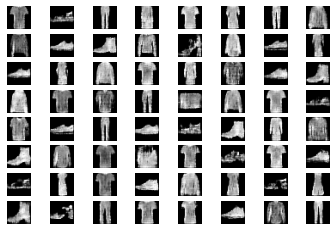

100%|██████████| 15/15 [01:38<00:00,  6.55s/it]


In [16]:
train_res_fmnist, model_fmnist = main(args)
train_res_fmnist = np.array(train_res_fmnist)

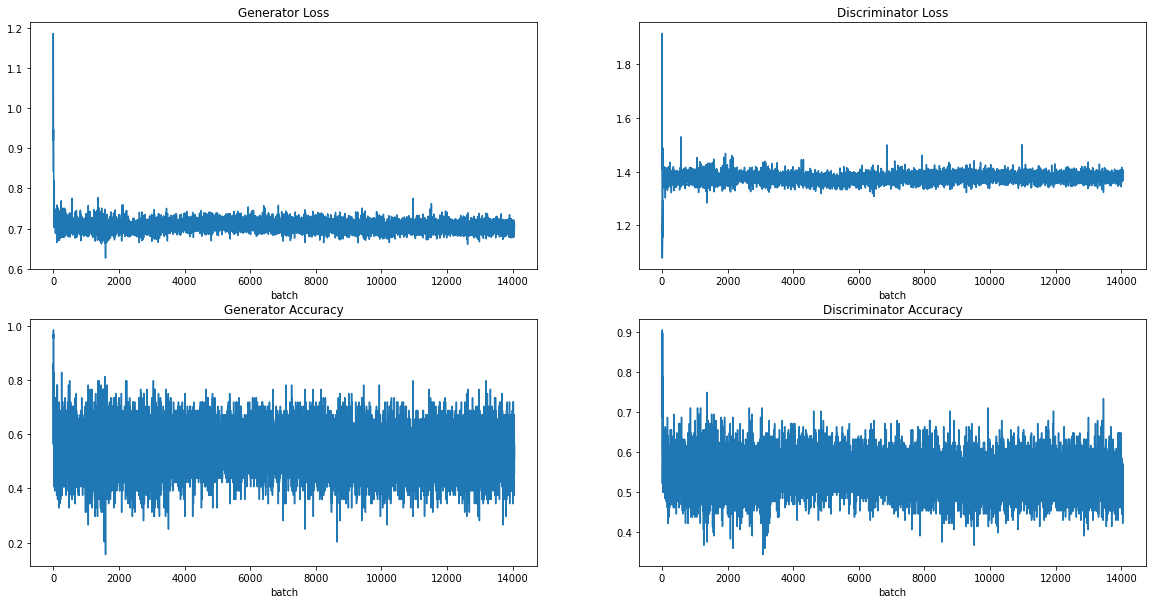

In [17]:
titles = ['Generator Loss','Discriminator Loss',
          'Generator Accuracy', 'Discriminator Accuracy']
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.reshape(-1)
for i in range(len(axes)):
    axes[i].plot(train_res_fmnist[i])
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('batch')

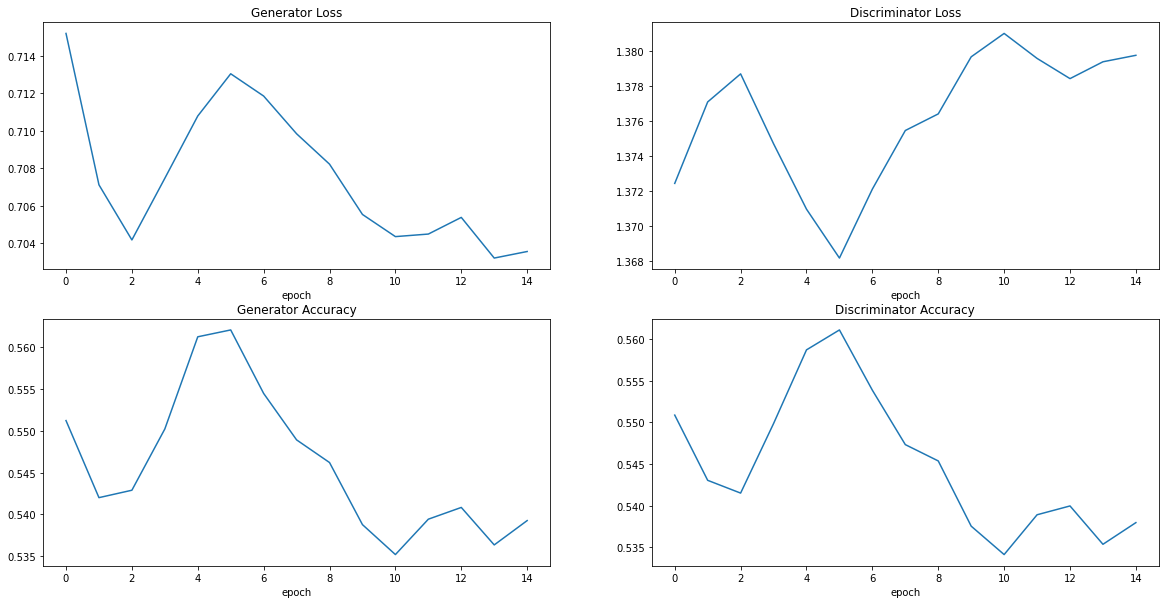

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.reshape(-1)
n_train = 60000
for i in range(len(axes)):
    train_log_epoch = batch_to_epoch(train_res_fmnist[i], n_train // args['batch_size'])
    axes[i].plot(range(len(train_log_epoch)), train_log_epoch, '-')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('epoch')

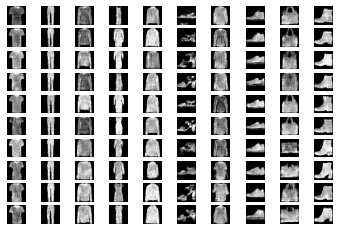

In [19]:
# Get the trained generator
trained_generator_fmnist = model_fmnist.g
# generate noise (latent_points) and labels
latent_points, _ = generate_latent_points(model_fmnist.z_dim, 100, 'uniform')
labels = asarray([x for _ in range(10) for x in range(10)])
labels = tf.one_hot(labels, 10).numpy()
# Get input to the generator
batch_z_to_disply = np.concatenate([latent_points, labels], 1)
X = trained_generator_fmnist(batch_z_to_disply, training=False)
# plot the result
imsave(X, size, show=True)

## Evaluation

In [20]:
# Get real disbrituion for each label.
# Image data: values are transformed to [0, 1],
#             same as that of generator outputs.
# Dictionary stats_real, example: stats[0] = [mean_0, cov_0]
stats_real = get_mean_cov_for_each_label(datasets='fashion_mnist')


# Calculate FID for each label.
# 1. For each label i,
#    use 1000 fake images to calculate the generated distribution.
# 2. Then calculate fid for each label using fake & real distribution.
nClass = 10
fake_num = 6400
stats_fake = {}

trained_generator_fmnist = model_fmnist.g # fmnist generator
latent_points, _ = generate_latent_points(model_fmnist.z_dim, fake_num, 'uniform')

for i in range(nClass):
    labels = np.full(shape=(fake_num,), fill_value=i, dtype=np.int32)
    labels = tf.one_hot(labels, 10).numpy()
    # Get input to the generator
    batch_z_to_disply = np.concatenate([latent_points, labels], 1)
    X = trained_generator_fmnist(batch_z_to_disply, training=False)
    fake_values = X.numpy().reshape(X.shape[0], -1)
    # generated values should be in [0, 1], because used sigmoid activation
    assert np.min(fake_values) >= -0.01 and np.max(fake_values) <= 1.01
    mean = fake_values.mean(axis=0)
    cov = np.cov(fake_values.T) # 784 x 784
    stats_fake[i] = [mean, cov]
    
fid_list = [] # smaller == better
for i in range(nClass):
    m, c = stats_real[i]
    m_fake, c_fake = stats_fake[i]
    fid_list.append(frechet_distance(m, c, m_fake, c_fake))

dataset fashion_mnist


/home/featurize/data/deep_learning_project/cgan/GANs-collections-tf2.0_keras-eager_mode/evaluation.py:59: Warning: Rank deficient covariance matrix, Frechet distance will not be accurate.
  'Frechet distance will not be accurate.', Warning)


In [21]:
fmnist_result = pd.DataFrame()
fmnist_result['label'] = [str(i) for i in range(nClass)] + ['average']
fmnist_result['Frechet Inception Distance - Fashion-MNIST'] = list(fid_list) + [np.mean(fid_list)]
fmnist_result.set_index('label')

,Frechet Inception Distance - Fashion-MNIST
label,
0,16.980800
1,13.442837
2,17.019885
3,13.100873
4,13.976745
5,14.612733
6,16.636067
7,9.074886
8,22.989426
